# **Independent States for each graph**

In [20]:
from langgraph.graph import START, END, StateGraph
from typing import TypedDict, List, Annotated
from langchain_ollama import ChatOllama

## **Creating subgraph first**


In [21]:
# subgraph state
class SubState(TypedDict):
    input_text: str
    translated_text: str

In [22]:
sub_llm = ChatOllama(model="deepseek-v3.1:671b-cloud", temperature=0.0)

In [23]:
# subgraph node for translating text coming from main graph

def translate_text(state: SubState):
    """This node will translate the input text to hindi language."""

    prompt = f"""translate the following text to hindi language. do not change the meaning. keep it natural and clear.
    \nTEXT: {state['input_text']}""".strip()

    response = sub_llm.invoke(prompt)

    return {"translated_text": response.content}

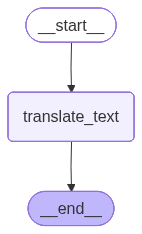

In [24]:
subgraph = StateGraph(SubState)

subgraph.add_node("translate_text", translate_text)
subgraph.add_edge(START, "translate_text")
subgraph.add_edge("translate_text", END)

sub_app = subgraph.compile()
sub_app

In [25]:
# sub_app.invoke({"input_text": "hi buddy how are you?"})

## **Creating Main Parent graph**


In [26]:
class ParentState(TypedDict):
    query: str
    eng_response: str
    hindi_response: str

In [27]:
parent_llm = ChatOllama(model="deepseek-v3.1:671b-cloud", temperature=0.7)

In [28]:
# main parent node for simple QnA

def parent_node(state: ParentState):
    """This node will take the user query and generate a response in english language."""

    prompt = f"""You are a helpful assistant. Answer the following query.
    \nQUERY: {state['query']}""".strip()

    response = parent_llm.invoke(prompt)

    return {"eng_response": response.content}

## **this node will connect the parent graph to the subgraph. which will only call the subgraph**


In [29]:
# second parent node which will call the subgraph

def call_subgraph(state: ParentState):
    """This node will call the subgraph to translate the english response to hindi."""

    english_response = state['eng_response']

    subgraph_response = sub_app.invoke({"input_text": english_response})

    hindi_response = subgraph_response['translated_text']

    return {"hindi_response": hindi_response}

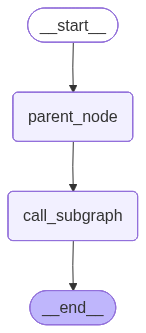

In [30]:
graph = StateGraph(ParentState)

graph.add_node("parent_node", parent_node)
graph.add_node("call_subgraph", call_subgraph)

graph.add_edge(START, "parent_node")
graph.add_edge("parent_node", "call_subgraph")
graph.add_edge("call_subgraph", END)

app = graph.compile()
app

In [31]:
response = app.invoke({
    "query": "why is sky blue?"
})

In [33]:
print(response["eng_response"])

Of course! That's an excellent question. The short answer is that the sky is blue because of the way Earth's atmosphere scatters sunlight.

Here’s a more detailed breakdown:

### 1. The Light from the Sun
Sunlight, which looks white to us, is actually a mixture of all the colors of the rainbow (red, orange, yellow, green, blue, indigo, violet). Each color has a different wavelength of light.

### 2. Earth's Atmosphere
Our atmosphere is filled with tiny gas molecules, mostly nitrogen and oxygen.

### 3. Rayleigh Scattering
This is the key scientific principle. When sunlight passes through the atmosphere, the tiny gas molecules are much better at scattering the light with **shorter wavelengths**—the blue and violet end of the spectrum—than the longer wavelengths, like red and orange.

Think of it like this: The smaller, shorter blue light waves hit the gas molecules and get bounced around (scattered) in all directions. The longer red light waves tend to pass straight through more easily.

In [34]:
print(response["hindi_response"])

Let’s tackle translating the breakdown of why the sky is blue into Hindi.

**Hindi Translation:**

यहाँ एक विस्तृत व्याख्या है कि आसमान नीला क्यों होता है:

1. **सूरज की रोशनी का विघटन:** सूरज की रोशनी हमें सफेद दिखती है, लेकिन वास्तव में इसमें इंद्रधनुष के सभी रंग (लाल, नारंगी, पीला, हरा, नीला, जामुनी, बैंगनी) शामिल होते हैं। प्रत्येक रंग का प्रकाश एक अलग तरंगदैर्ध्य (wavelength) पर होता है।

2. **पृथ्वी का वायुमंडल:** हमारा वायुमंडल गैस के छोटे-छोटे अणुओं (जैसे नाइट्रोजन और ऑक्सीजन) से भरा हुआ होता है।

3. **रेले का प्रकीर्णन:** यही मुख्य वैज्ञानिक सिद्धांत है। जब सूरज की रोशनी वायुमंडल से गुजरती है, तो ये छोटे गैस अणु छोटे तरंगदैर्ध्य वाले प्रकाश (नीला और बैंगनी) को अधिक प्रभावी ढंग से बिखेरते (scatter) देते हैं।

इसे ऐसे समझें: नीले प्रकाश की तरंगें लाल प्रकाश की तुलना में छोटी होती हैं। ये नीली तरंगें वायुमंडल के अणुओं से टकराकर हर दिशा में बिखर जाती हैं।

4. **आसमान का रंग:** जब आप आसमान की तरफ देखते हैं (सीधे सूरज की ओर नहीं), तो यह बिखरा हुआ नीला प्रकाश आपकी आंखों तक पहुंचता है